## **Introducción**

En un transformador de alta tensión, qué factor marcaría su fin de vida útil?

La respuestá está en la aislación sólida, es decir el papel que aisla sus devanados. El fallo de este elemento, es determinante en su vida útil y su deterioro marca directamente su fin de vida.

Entendiendo lo crucial que es un transformador elevador de tensión en la línea de producción de una central eléctrica, el tiempo que toma adquirir uno nuevo y su elevado coste, es que la detección temprana de "síntomas" que podrían conducir al fallo ha tomado suma relevancia, donde se tratan de indentificar comportamientos anómalos en su funcionamiento.





## **Contexto**

En el caso que se pretende analizar, se trata de una central eléctrica que lleva más de 20 años de operación, aportando energía al sistema interconectado nacional. Esta posee su parque de transformadores que cuenta con tres transformadores elevadores de tensión.

Un transformador operando a régimen normal y habitual produce temperatura en sus devanados la cual es disipada a través del aceite dieléctrico y sus respectivos enfriadores. Este proceso térmico va produciendo paulatinamente un deterioro en la aislación sólida (aislación del devanado) y en el aceite dieléctrico.

La compañía trabaja con un sistema de adquisición de datos en tiempo real pero no incorpora ningún sistema de aprendizaje automático para el análisis, pero es posible introducir funciones complementarias para el análisis y que con éstas genere automáticamente notificaciones o alarmas tempranas.

El set de datos del que se dispone, está compuesto por valores como potencia activa, potencia reactiva, tensión de campo, corriente estatórica, temperaturas de aceite 1 y 2 de transformador principal, temperatura de devanado del transformador y temperatura ambiente.

# **Hipótesis, preguntas de interés y objetivo general.**

Hipótesis

1.   	Hipótesis nula: No existe una relación significativa entre la potencia activa, corriente estatórica y temperatura ambiente con la temperatura del transformador
2.   Hipótesis alternativa: Existe una relación significativa entre la potencia activa, corriente estatórica y temperatura ambiente con la temperatura del transformador



Preguntas de Interés

*   ¿Existe una correlación entre la potencia activa generada por el generador y las temperaturas del transformador?
*   ¿Existe una correlación entre la corriente estatórica del generador y las temperaturas del transformador?
* ¿Es posible utilizar un modelo de regresión lineal para predecir las temperaturas del transformador basándonos en estas variables?



Objetivo General

En primera instancia, hallar un modelo de regresión que ayude a detectar apartamientos en las temperaturas del devanado, con respecto a lo esperado por el modelo. Luego obtener parámetros como coeficientes e intercepto del modelo, para incoporarlo en el sistema de la compañía y lograr un seguimiento online en tiempo real.

# **Los datos:**





Los datos son extraídos directamente del sistema de adquisición de datos de la central. Donde se tienen Temperatura Ambiente, Temperatura de aceite 1 y 2, Temperatura de devanado, Potencia activa MW, Potencia reactiva, Corrientes estatóricas de las 3 fases, Frecuencia de Generación y Tensiones estatóricas de las 3 fases. El muestreo es cada 30 minutos desde el 2022-05-05 hasta
abril del corriente año.








## **Importación y primer acercamiento**

De un rápido vistazo del dataset, se pueden observar que son necesarias varias acciones antes de realizar las visualizaciones


*   Eliminar filas donde Potencia Activa es menor a 38 Mw, ya que valores por debajo no corresponden a máquina en servicio

*   Es necesario redondear los valores de Temperaturas a solo un decimal, y la columna de Potencia activa, debe ser un número entero, esto es para eliminar "ruido" en los datos.


*   Cambiar tipo de datos que contienen las celdas, ya que viene como 'object.



In [1]:
# @title
import pandas     as pd
import seaborn    as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# @title

from google.colab import drive
drive.mount('mi_carpeta')


%cd /content/mi_carpeta/MyDrive/Colab Notebooks/DATOS de análisis/
%ls

df = pd.read_excel("U3_trafo_temp.xlsx")

df.head(2)

Mounted at mi_carpeta
/content/mi_carpeta/MyDrive/Colab Notebooks/DATOS de análisis
'Datos TPU3_Validacion'/    TPU3_predict.ipynb   U3_trafo_temp.xlsx
 ProyectoDS_Hidalgo.ipynb   U3_trafo_3.xlsx      Untitled0.ipynb


,Fecha,TEMPERATURA AMBIENTE,TEMP ACEITE 1 TRAFO,TEMP ACEITE 2 TRAFO,TEMP DEVANADO TRAFO,POTENCIA ACTIVA,POTENCIA REACTIVA,CORRIENTE ESTATORICA FASE U,CORRIENTE ESTATORICA FASE V,CORRIENTE ESTATORICA FASE W,FRECUENCIA GENERACION,TENSION ESTATORICA FASE U,TENSION ESTATORICA FASE V,TENSION ESTATORICA FASE W
0,2022-05-05 00:00:00,No Data,17.478323,16.162203,18.046711,0.260625,-0.289856,0.000767,0.002109,0.000775,44.987968,0.025381,0.003526,0.039094
1,2022-05-05 00:30:00,No Data,17.147207,15.843233,17.751373,0.260625,-0.174232,0.000762,0.002109,0.000768,44.988243,0.025663,0.003245,0.039094


In [3]:
# @title
df = df.apply(pd.to_numeric, errors='coerce')
df = df.round(1)
df['POTENCIA ACTIVA'] = df['POTENCIA ACTIVA'].dropna().round().astype(int)  #---> PotenciaAct, se redondea para convertirlo a número entero


filtro_potencia = df['POTENCIA ACTIVA'] > 38
df_filtrado = df[filtro_potencia]

# **Feature selection**

### Correlaciones

Al tratarse de datos de generación eléctrica están todos relacionados entre sí, con mayor o menor fuerza.  Para reducir la dimensionalidad del set de datos, se utilizará un método de cálculo de correlaciones entre las variables involucradas. Con esto conseguiremos descartar aquellas variables que guardan poca o ninguna correlación con nuestra variable objetivo, entendiendo también que algunas de ellas son redundantes.


*Se realizan los cálculos de correlaciones para las variables de mayor interés "TEMP DEVANADO TRAFO":*, definiendo el umbral de correlación a "0.4" , por encima de este umbral se tomará como una correlación moderada. Y se filtrarán las columnas por encima de este valor. **Esto se logrará reducir la dimensión del Dataframe.**.

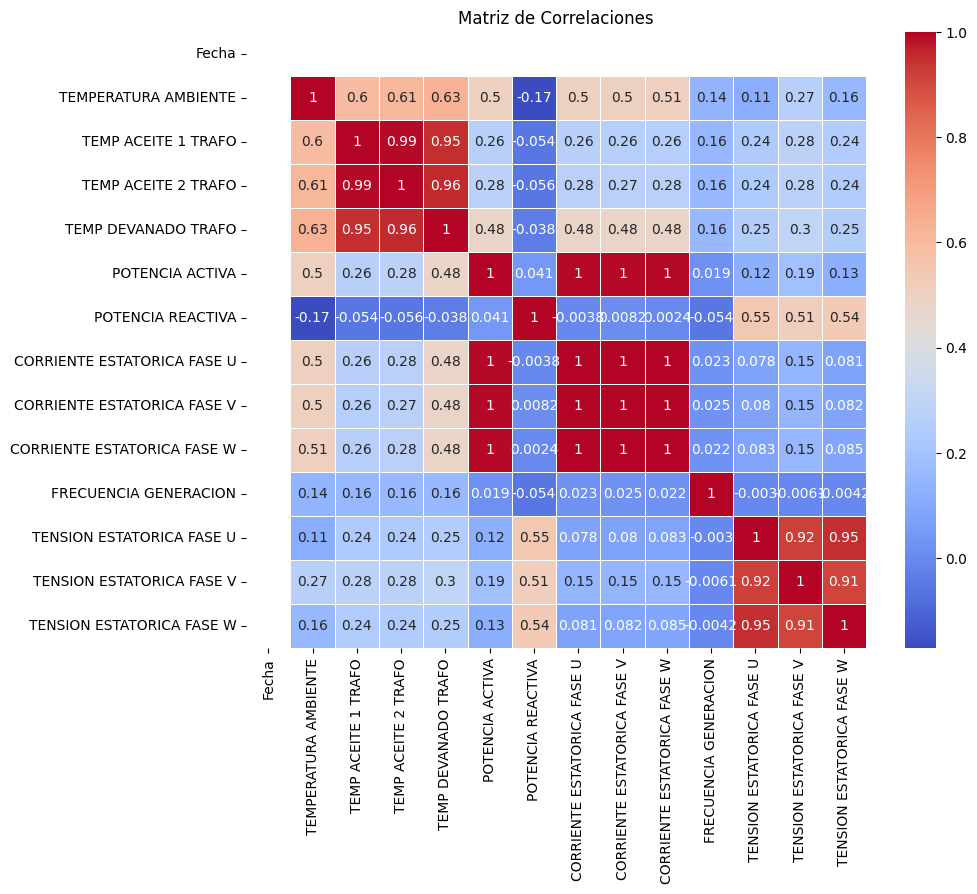

In [4]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

correlacion_m = df_filtrado.corr()

plt.figure(figsize=(10, 8))  # tamaño de la figura
sns.heatmap(correlacion_m, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()

In [10]:
# @title
nombres_columnas = df_filtrado.columns



print(nombres_columnas)

Index(['Fecha', 'TEMPERATURA AMBIENTE', 'TEMP ACEITE 1 TRAFO',
       'TEMP ACEITE 2 TRAFO', 'TEMP DEVANADO TRAFO', 'POTENCIA ACTIVA',
       'POTENCIA REACTIVA', 'CORRIENTE ESTATORICA FASE U',
       'CORRIENTE ESTATORICA FASE V', 'CORRIENTE ESTATORICA FASE W',
       'FRECUENCIA GENERACION', 'TENSION ESTATORICA FASE U',
       'TENSION ESTATORICA FASE V', 'TENSION ESTATORICA FASE W'],
      dtype='object')


In [5]:
# @title
correlacion = df_filtrado.corr()['TEMP DEVANADO TRAFO']

umbral = 0.4   # ---> umbral de correlación
selected_columns = correlacion[correlacion.abs() > umbral].index

df_corr = df_filtrado[selected_columns]
#df_corr.head(2)

Luego de calcular las correlaciones determinamos que es posible prescindir de algunas variables que no tienen gran correlación con el objetivo que buscamos. **Con esto logramos reducir la dimensión de nuestro Dataframe eliminando las siguientes variables:**


*   Potencia Reactiva
*   Frecuencia de Línea
*   Tensiones Estatóricas U, V y W



In [6]:
df_corr.describe()

,TEMPERATURA AMBIENTE,TEMP ACEITE 1 TRAFO,TEMP ACEITE 2 TRAFO,TEMP DEVANADO TRAFO,POTENCIA ACTIVA,CORRIENTE ESTATORICA FASE U,CORRIENTE ESTATORICA FASE V,CORRIENTE ESTATORICA FASE W
count,3932.000000,10856.000000,10850.000000,10852.000000,10857.000000,10855.000000,10855.000000,10855.000000
mean,11.297787,54.042428,52.469438,69.952801,52.778760,2.192262,2.235237,2.170631
std,5.877402,7.090144,6.981139,8.073606,14.927109,0.599474,0.603170,0.609536
min,-3.000000,2.800000,1.000000,13.500000,39.000000,1.500000,1.600000,1.500000
25%,6.900000,50.800000,49.100000,66.000000,40.000000,1.700000,1.700000,1.700000
50%,10.700000,54.200000,52.600000,69.700000,42.000000,1.800000,1.900000,1.800000
75%,14.600000,58.200000,56.700000,74.200000,66.000000,2.700000,2.700000,2.700000
max,30.100000,70.500000,68.700000,91.100000,96.000000,4.000000,4.000000,3.900000


# **Graficos**

**Variables a definir que se usarán para las visualizaciones**

Del "df_corr" tomamos todas las columnas como variables menos las de corrientes estatóricas, al tratarse de un generador trifásico podemos inferir que son iguales o muy aproximadas, solo tomamos una.



Se procede a definir las variables:

In [ ]:
# @title
pot_activa = df_corr['POTENCIA ACTIVA']
temp_aceite1 = df_corr['TEMP ACEITE 1 TRAFO']
temp_aceite2 = df_corr['TEMP ACEITE 2 TRAFO']
temp_devanado = df_corr['TEMP DEVANADO TRAFO']
corriente_est = df_corr['CORRIENTE ESTATORICA FASE U']

In [ ]:
# @title
import plotly.graph_objects as go
import numpy as np


# Histogramas
hist_temp_devanado = go.Histogram(x=temp_devanado, opacity=0.75, name='Temperatura devanado', histnorm='probability')
hist_temp_aceite1 = go.Histogram(x=temp_aceite1, opacity=0.75, name='Temperatura Aceite 1', histnorm='probability')
hist_temp_aceite2 = go.Histogram(x=temp_aceite2, opacity=0.75, name='Temperatura Aceite 2', histnorm='probability')


fig = go.Figure(data=[hist_temp_devanado, hist_temp_aceite1, hist_temp_aceite2])

# diseño de la figura
fig.update_layout(
    title="Distribución Temperaturas en Transformador",
    xaxis_title="Temp. °C",
    yaxis_title="Probabilidad",
    barmode='overlay'  #  superponer los histogramas
)


fig.show()



* Del histograma se puede observar que son coincidentes las frecuencias con las que se producen los valores del conjunto de datos "Temperatura Aceite" 1 y 2, ya que son dos instrumentos a cada lado del equipo, lo que indicaría que la temperatura se produce de forma medianamente uniforme en todo el equipo.

* De "Temperatura devanado" se puede obtener que frecuentemente funciona lejos de valores térmicos dañinos para la aislación del equipo (90 °c)

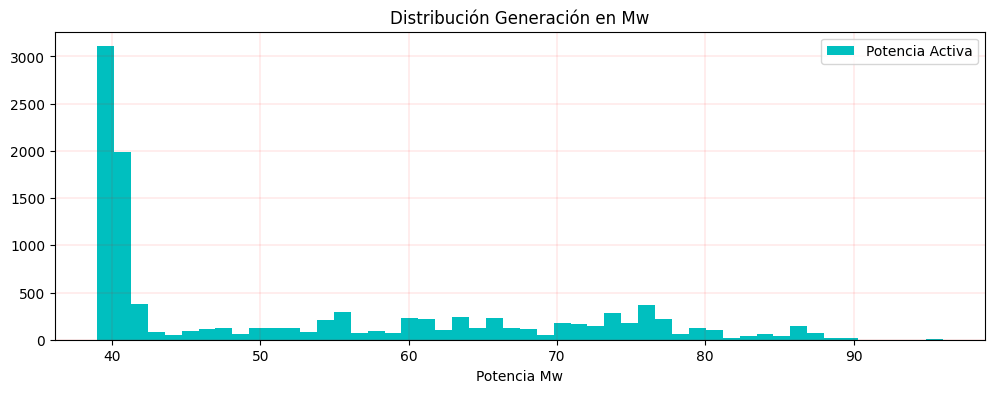

In [ ]:
# @title

fig, ax2 = plt.subplots(figsize=(12,4))

ax2.hist(pot_activa, color='c', bins=50, label='Potencia Activa')

ax2.set_xlabel("Potencia Mw")
ax2.legend()
ax2.set_title("Distribución Generación en Mw")
ax2.grid(color='r', linewidth=0.1)


+* Del Histograma de "Generación en Mw" podemos inferir que frecuentemente la producción de energía ronda el escalón mínimo de operación en torno a los 40 Mw.
* También se pueden observar marcados escalones de operación a los 55, 63, 65 y 75 Mw, esto resulta coincidente con el caudal erogado y la "Norma de manejo de agua".

Text(0.5, 1.0, 'Distribución de Temp °C según Potencia Activa')

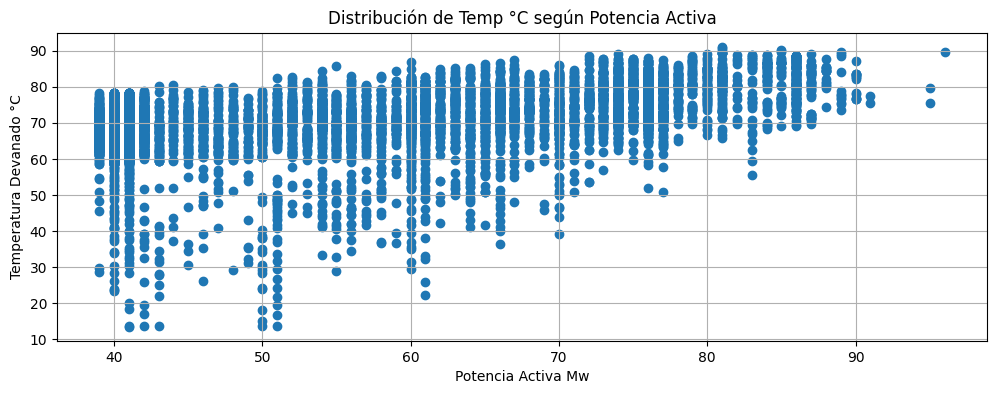

In [ ]:
# @title
fig, ax  = plt.subplots(figsize=(12,4))

ax.scatter(pot_activa, temp_devanado)
ax.grid()
ax.set_xlabel("Potencia Activa Mw")
ax.set_ylabel("Temperatura Devanado °C")
ax.set_title("Distribución de Temp °C según Potencia Activa")

Text(0.5, 1.0, 'Distribución de Temp °C según Corriente Estatórica')

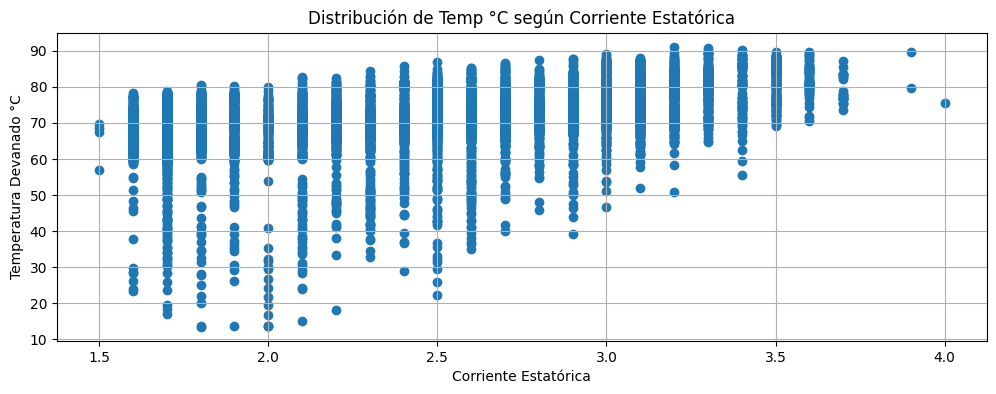

In [ ]:
# @title
fig, ax  = plt.subplots(figsize=(12,4))

ax.scatter(corriente_est, temp_devanado)
ax.grid()
ax.set_xlabel("Corriente Estatórica")
ax.set_ylabel("Temperatura Devanado °C")
ax.set_title("Distribución de Temp °C según Corriente Estatórica")

* Como variables de interés, se realizan dos gráficos de distribución para observar la relación que guardan "Temp. Devanado" con "Potencia Activa" y "Corriente Estatórica"
* En el primer gráfico pareciera existir una correlación a aumentar la temperatura mientras aumenta la potencia generada. También hay datos que parecieran espurios que serían objeto de estudio.
* Para el segundo gráfico se puede observar una evidente relación entre el aumento de la corriente estatórica y la Temperatura en el devanado del transformador.

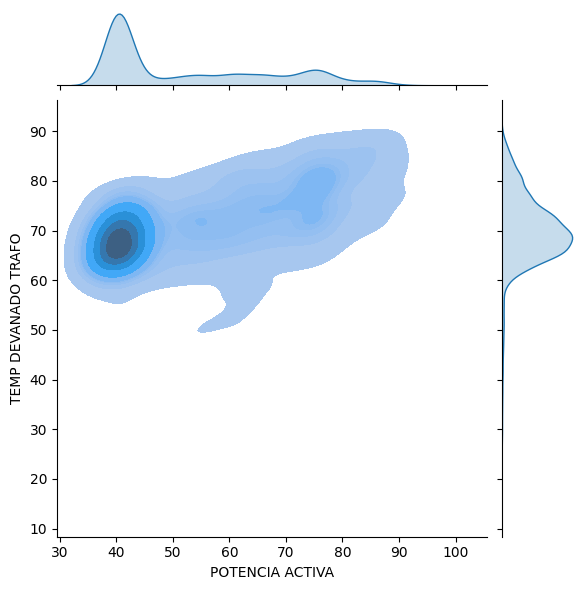

In [ ]:
# @title
sns.jointplot(data=df_filtrado, x='POTENCIA ACTIVA', y='TEMP DEVANADO TRAFO', kind='kde', fill="true")

Se realiza una Visualización de distribución bivariado con datos de Potencia Activa y Temp. Devanado Trafo para combinar las densidades de datos. En él se pude observar que hay una mayor probabilidad de que los valores de ambas variables caigan entorno a 40 Mw (lo cual es lógico ya que es la potencia más operada) y 63°C para la Temperatura del Devanado del transformador principal

In [ ]:
# @title
import plotly.graph_objects as go
import pandas as pd

# Supongamos que tienes un DataFrame df_filtrado con las columnas POTENCIA ACTIVA, TEMP DEVANADO TRAFO, TEMP ACEITE 1 TRAFO, TEMP ACEITE 2 TRAFO

# Crear un boxplot en Plotly
fig = go.Figure()

# Agregar un boxplot para cada columna
columnas = ['POTENCIA ACTIVA', 'TEMP DEVANADO TRAFO', 'TEMP ACEITE 1 TRAFO', 'TEMP ACEITE 2 TRAFO']
for columna in columnas:
    fig.add_trace(go.Box(y=df_filtrado[columna], name=columna))

# Personalizar el diseño del gráfico
fig.update_layout(
    title='Quartiles y valores atípicos',
    xaxis=dict(
        tickangle=-45,
        tickfont=dict(size=7)
    )
)

# Mostrar el gráfico
fig.show()



*   Potencia activa muestra una distribución asimétrica positiva, sin valores atípicos
*   Mientras que los datos de Temperaturas de aceite 1 y 2, y Temperatura de Devanado, son mayormente simétricos pero ***presentan muchos valores atípicos***
Estos valores atípicos son originados por lecturas de temperatura cuando el generador y todos los sistemas han arrancando y no han alcanzado la estabilidad térmica propia del sistema a régimen normal.

# **Conclusiones**

Como se ha podido inferir, la hipótesis alternativa resulta ser verdadera, existe una relación significativa entre la potencia activa, corriente estatórica y temperatura ambiente para con la temperatura desarrollada en el devanado del transformador, además que podría ser explicada mediante una regresión lineal. Obteniendo una regresión lineal, podemos obtener coeficientes e intercepto, estos pueden ser introducidos en una función de análisis dentro del sistema de la compañía.
Por esto mismo también se demuestra la fuerte correlación que guardan estas variables.